# Weapon Damage

## Setting Up

In [1]:
import pandas as pd
import calendar
from weapon import max_shots, burst

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

## Data Merge

In [2]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Chance to Hit

Soldiers start with an Accuracy value between 40 and 70, giving an average of 55.

To get the change of hit this should by applied to the weapon accuracy. Just multiply them as proportions. So an average of 55 to a weapon of Accuracy 90 means 0.55 * 0.9 = 0.495 chance of hit.

In [3]:
weapon_attacks["chance_to_hit"] = weapon_attacks.apply(lambda x: x["accuracy"] / 100 * 0.55, axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760


## Derived Damage

In [4]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["expected_damage"] = weapon_attacks.apply(lambda x: x["damage"] * x["chance_to_hit"], axis=1)
weapon_attacks["clip_damage"] = weapon_attacks.apply(lambda x: x["capacity"] * x["damage"], axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks["turns_to_reload"] = weapon_attacks.apply(lambda x: x["capacity"] / x["turn_max_shots"], axis=1)
weapon_attacks["turn_damage_max"] = weapon_attacks.apply(lambda x: x["turn_max_shots"] * x["damage"], axis=1)
weapon_attacks["turn_damage_expected"] = weapon_attacks.apply(lambda x: x["turn_damage_max"] * x["chance_to_hit"], axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,32.175,90.0,1.269841,0.787500,114.285714,40.857143
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,18.942,588.0,1.250000,11.200000,52.500000,23.677500
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,19.844,616.0,1.250000,11.200000,55.000000,24.805000
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,21.648,672.0,1.250000,11.200000,60.000000,27.060000
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,7.392,588.0,7.500000,1.866667,315.000000,55.440000


## Damage Ranking

### Most Damaging Weapon

In a single turn, shooting as much as possible, which weapon does the most damage.

This takes into account reloading.

In [5]:
most_damaging_weapon = weapon_attacks[["weapon", "turn_damage_expected"]]
most_damaging_weapon = most_damaging_weapon.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon = most_damaging_weapon.groupby("weapon").max()
most_damaging_weapon = most_damaging_weapon.sort_values(by=["turn_damage"])
most_damaging_weapon

,turn_damage
weapon,
grenade,22.698413
proximity_grenade,31.777778
alien_grenade,40.857143
pistol,47.666667
rifle,49.500000
high_explosive,49.936508
cannon_turret,60.000000
heavy_cannon,60.000000
auto_cannon,63.360000


Text(0, 0.5, 'Damage')

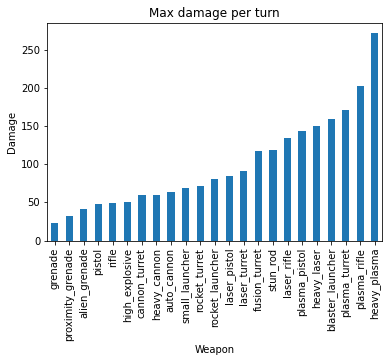

In [6]:
ax = most_damaging_weapon.plot.bar(title="Max damage per turn", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Snapshot

In [7]:
most_damaging_weapon_snap = weapon_attacks[weapon_attacks["fire_mode"] == "snapshot"]
most_damaging_weapon_snap = most_damaging_weapon_snap[["weapon", "turn_damage_expected"]]
most_damaging_weapon_snap = most_damaging_weapon_snap.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_snap = most_damaging_weapon_snap.groupby("weapon").max()
most_damaging_weapon_snap = most_damaging_weapon_snap.sort_values(by=["turn_damage"])
most_damaging_weapon_snap

,turn_damage
weapon,
rifle,39.600000
auto_cannon,44.800000
pistol,47.666667
laser_pistol,50.600000
rocket_launcher,56.807512
rocket_turret,57.138889
cannon_turret,60.000000
heavy_cannon,60.000000
plasma_pistol,61.966667


Text(0, 0.5, 'Damage')

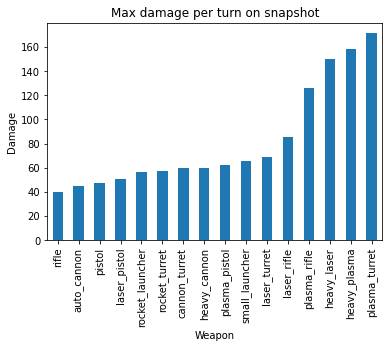

In [8]:
ax = most_damaging_weapon_snap.plot.bar(title="Max damage per turn on snapshot", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Aimed

In [9]:
most_damaging_weapon_aim = weapon_attacks[weapon_attacks["fire_mode"] == "aimed"]
most_damaging_weapon_aim = most_damaging_weapon_aim[["weapon", "turn_damage_expected"]]
most_damaging_weapon_aim = most_damaging_weapon_aim.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_aim = most_damaging_weapon_aim.groupby("weapon").max()
most_damaging_weapon_aim = most_damaging_weapon_aim.sort_values(by=["turn_damage"])
most_damaging_weapon_aim

,turn_damage
weapon,
rifle,22.687500
auto_cannon,27.060000
laser_pistol,31.280000
cannon_turret,37.125000
heavy_cannon,37.125000
pistol,37.180000
plasma_pistol,40.516667
laser_rifle,66.000000
small_launcher,69.142857


Text(0, 0.5, 'Damage')

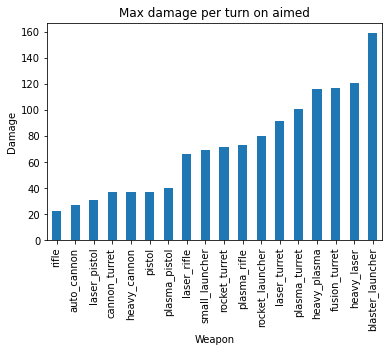

In [10]:
ax = most_damaging_weapon_aim.plot.bar(title="Max damage per turn on aimed", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Auto

In [11]:
most_damaging_weapon_auto = weapon_attacks[weapon_attacks["fire_mode"] == "auto"]
most_damaging_weapon_auto = most_damaging_weapon_auto[["weapon", "turn_damage_expected"]]
most_damaging_weapon_auto = most_damaging_weapon_auto.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_auto = most_damaging_weapon_auto.groupby("weapon").max()
most_damaging_weapon_auto = most_damaging_weapon_auto.sort_values(by=["turn_damage"])
most_damaging_weapon_auto

,turn_damage
weapon,
rifle,49.500000
auto_cannon,63.360000
laser_pistol,85.008000
laser_rifle,133.941176
plasma_pistol,143.000000
plasma_rifle,201.666667
heavy_plasma,271.071429


Text(0, 0.5, 'Damage')

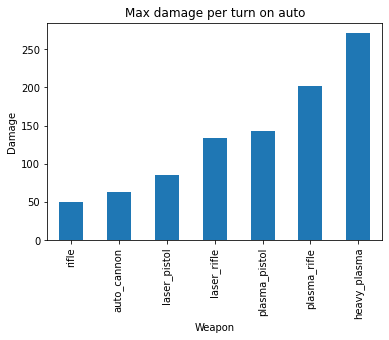

In [12]:
ax = most_damaging_weapon_auto.plot.bar(title="Max damage per turn on auto", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Most Damaging Grenade

In [13]:
most_damaging_weapon_grenade = weapon_attacks[weapon_attacks["fire_mode"] == "grenade"]
most_damaging_weapon_grenade = most_damaging_weapon_grenade[["weapon", "turn_damage_expected"]]
most_damaging_weapon_grenade = most_damaging_weapon_grenade.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_grenade = most_damaging_weapon_grenade.set_index(["weapon"])
most_damaging_weapon_grenade = most_damaging_weapon_grenade.sort_values(by=["turn_damage"])
most_damaging_weapon_grenade

,turn_damage
weapon,
grenade,22.698413
proximity_grenade,31.777778
alien_grenade,40.857143
high_explosive,49.936508


Text(0, 0.5, 'Damage')

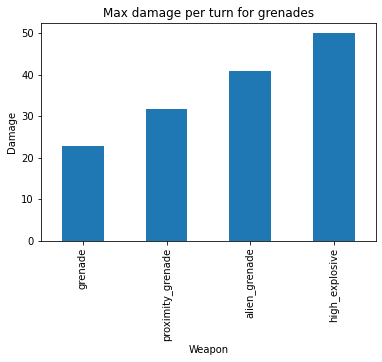

In [14]:
ax = most_damaging_weapon_grenade.plot.bar(title="Max damage per turn for grenades", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")